# Machine Learning Fundamentals: A Comprehensive Hands-On Lab

## Lab Overview

This lab covers the core concepts of machine learning through theory and practice:

1. **Automatic Differentiation** - How gradients are computed efficiently
2. **Linear Regression** - The foundation of machine learning
3. **Loss Functions** - Measuring model quality  
4. **Gradient Descent** - The standard optimization algorithm
5. **LBFGS** - Advanced second-order optimization
6. **Kernel Methods** - Handling non-linear relationships
7. **Probabilistic View** - Maximum likelihood and probability density

**Note**: Complete cells marked with `# YOUR CODE HERE` and remove `raise NotImplementedError()`

## Part 1: Automatic Differentiation

### Theory: How Do We Compute Gradients?

**Automatic differentiation** is the engine behind modern machine learning. It computes exact derivatives efficiently.

#### Three Approaches to Differentiation:

1. **Symbolic**: Derive analytical formulas (slow, memory-intensive)
2. **Numerical**: $\frac{df}{dx} \approx \frac{f(x+h) - f(x)}{h}$ (inaccurate)
3. **Automatic**: Use chain rule computationally (fast, exact!)

#### The Chain Rule

For composite functions $f(g(x))$:
$$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

For computational graph $x \rightarrow f_1 \rightarrow f_2 \rightarrow ... \rightarrow f_n \rightarrow L$:
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f_n} \cdot \frac{\partial f_n}{\partial f_{n-1}} \cdot ... \cdot \frac{\partial f_2}{\partial f_1} \cdot \frac{\partial f_1}{\partial x}$$

#### Forward vs Backward Mode

- **Forward**: Compute $\frac{\partial f_i}{\partial x}$ from left to right
- **Backward (Backprop)**: Compute $\frac{\partial L}{\partial f_i}$ from right to left

For ML (many params, few outputs): **backward mode wins!**

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch.optim as optim

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Demo: Automatic differentiation
x = torch.tensor(3.0, requires_grad=True)
f = x**2 + 2*x

print(f"f(3) = {f.item()}")
f.backward()
print(f"df/dx at x=3: {x.grad.item()}")
print(f"Analytical: 2x+2 = {2*3+2}")

f(3) = 15.0
df/dx at x=3: 8.0
Analytical: 2x+2 = 8


### Exercise 1.1: Compute Multivariable Gradients

Compute $\nabla f$ for $f(x,y) = x^2y + \sin(x)$ at $(2, 3)$

In [7]:

def gradientF (x, y):

    xGrad = 2*x*y+np.cos(x)
    yGrad = x**2

    return [xGrad, yGrad]

x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)
f= x**2 *y +torch.sin(x)

f.backward()
print(f"f(2, 3)={f.item()}")
print(f"df/dx(x=2, y=3) = {x.grad.item()}")
print(f"df/dy(x=2, y=3) = {y.grad.item()}")

print(gradientF(2, 3))


f(2, 3)=12.909296989440918
df/dx(x=2, y=3) = 11.583852767944336
df/dy(x=2, y=3) = 4.0
[np.float64(11.583853163452858), 4]


## Part 2: Linear Regression

### Theory: The Simplest Machine Learning Model

Given data $(x_i, y_i)$, find linear function:
$$\hat{y} = wx + b$$

**Goal**: Minimize prediction error
$$\min_{w,b} \sum_{i=1}^{n} (wx_i + b - y_i)^2$$

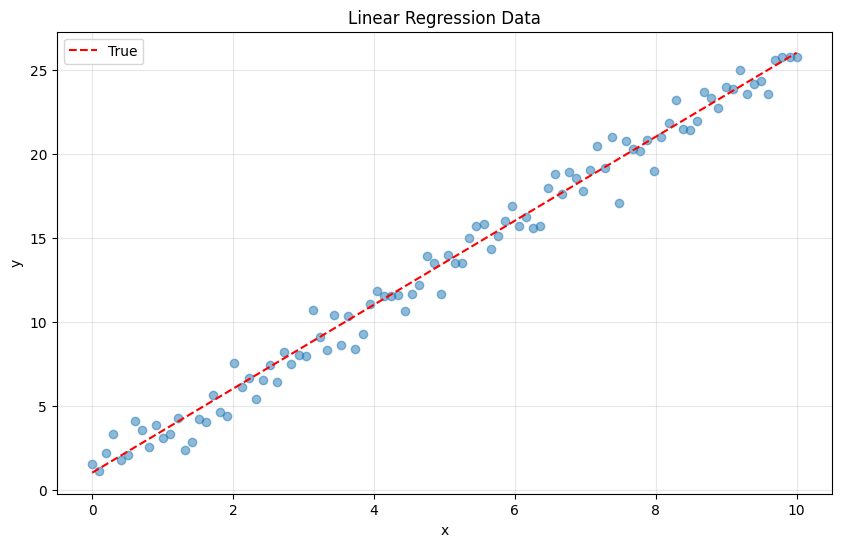

In [5]:
# Generate data: y = 2.5x + 1.0 + noise
n = 100
w_true, b_true = 2.5, 1.0
x_data = np.linspace(0, 10, n)
y_data = w_true * x_data + b_true + np.random.normal(0, 1, n)

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_data, w_true*x_data + b_true, 'r--', label='True')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Linear Regression Data')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

### Exercise 2.1: Implement Analytical Solution

Fitted: w=2.514, b=0.827
True: w=2.5, b=1.0


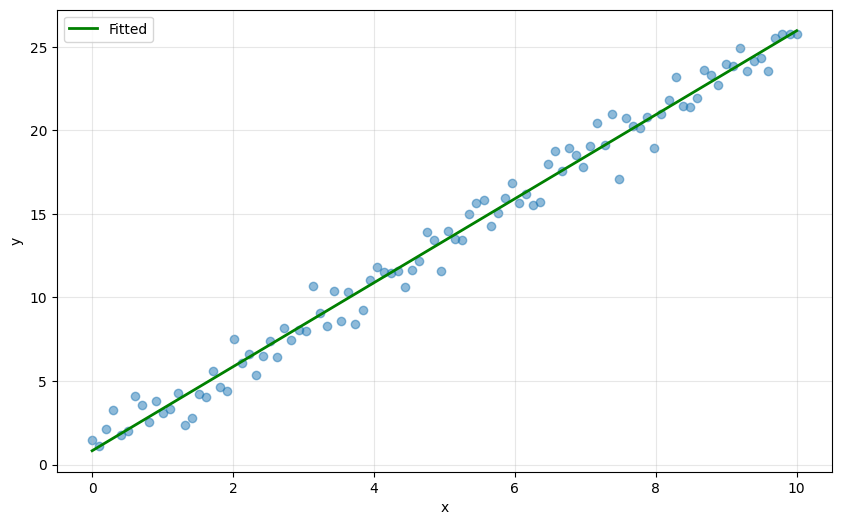

In [15]:
def analytical_linreg(x, y):
    """Closed-form linear regression"""
    
    xAvg = np.mean(x)
    yAvg = np.mean(y)

    w = np.sum((x-xAvg)*(y-yAvg))/np.sum((x-xAvg)**2)
    b = yAvg - w * xAvg

    return (w, b)

w_opt, b_opt = analytical_linreg(x_data, y_data)
print(f"Fitted: w={w_opt:.3f}, b={b_opt:.3f}")
print(f"True: w={w_true}, b={b_true}")

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_data, w_opt*x_data + b_opt, 'g-', label='Fitted', linewidth=2)
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

## Part 3: Loss Functions

### Theory: Measuring Prediction Quality

A **loss function** $L(\theta)$ quantifies model error.

#### Mean Squared Error (MSE)
$$L_{MSE} = \frac{1}{n}\sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

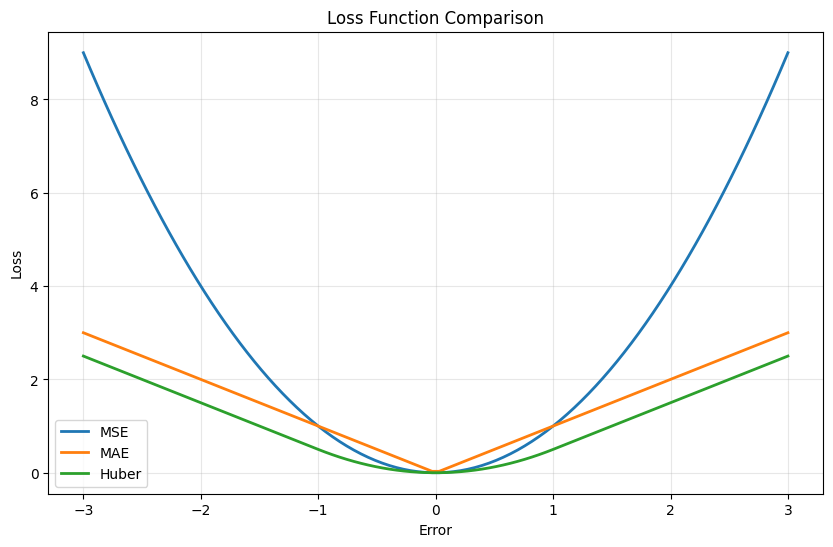

In [16]:
# Visualize loss functions
errors = np.linspace(-3, 3, 100)
mse = errors**2
mae = np.abs(errors)
huber = np.where(np.abs(errors) <= 1, 0.5*errors**2, np.abs(errors) - 0.5)

plt.figure(figsize=(10, 6))
plt.plot(errors, mse, label='MSE', linewidth=2)
plt.plot(errors, mae, label='MAE', linewidth=2)
plt.plot(errors, huber, label='Huber', linewidth=2)
plt.xlabel('Error'); plt.ylabel('Loss')
plt.title('Loss Function Comparison')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

## Part 4: Gradient Descent

### Theory: Iterative Optimization

**Gradient descent** minimizes $L(\theta)$ iteratively:
$$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$$

### Exercise 4.1: Implement Gradient Descent

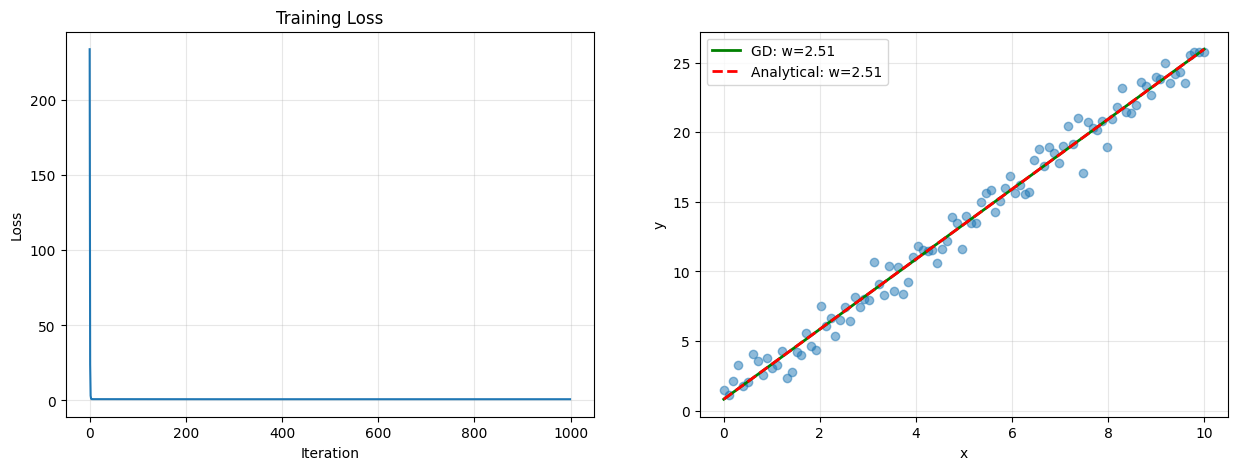

In [23]:
def gradient_descent(x, y, lr=0.01, n_iter=1000):
    """Optimize w,b using gradient descent"""
    w = 0.0
    b = 0.0
    n = len(x)
    
    losses = []
    w, b = (0, 0)

    for i in range(n_iter):
        y_pred = w * x + b
        error = y_pred - y
        loss = np.mean(error**2)
        losses.append(loss)

        dw = (2/n)*np.sum(error*x)
        db = (2/n)*np.sum(error)

        w = w - lr*dw
        b = b - lr*db

    return (w, b, losses)

w_gd, b_gd, losses = gradient_descent(x_data, y_data, lr=0.01, n_iter=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(losses)
ax1.set_xlabel('Iteration'); ax1.set_ylabel('Loss')
ax1.set_title('Training Loss'); ax1.grid(alpha=0.3)

ax2.scatter(x_data, y_data, alpha=0.5)
ax2.plot(x_data, w_gd*x_data + b_gd, 'g-', label=f'GD: w={w_gd:.2f}', linewidth=2)
ax2.plot(x_data, w_opt*x_data + b_opt, 'r--', label=f'Analytical: w={w_opt:.2f}', linewidth=2)
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.legend(); ax2.grid(alpha=0.3)
plt.show()

## Part 5: Advanced Optimization - LBFGS

### Theory: Second-Order Methods

Gradient descent uses only first derivatives. **Second-order methods** use curvature information from the Hessian matrix.

SGD: w=2.547, b=0.607, final loss=0.827378
Adam: w=1.139, b=1.132, final loss=60.797516
LBFGS: w=2.514, b=0.827, final loss=0.814905


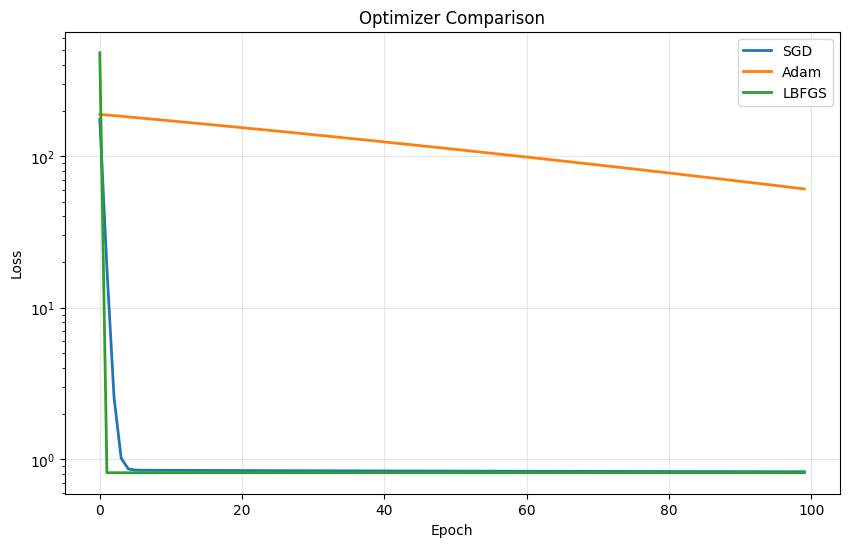

In [24]:
# Compare optimizers
x_t = torch.FloatTensor(x_data).reshape(-1, 1)
y_t = torch.FloatTensor(y_data).reshape(-1, 1)

def train_optimizer(opt_name, n_epochs=100):
    w = torch.randn(1, requires_grad=True)
    b = torch.randn(1, requires_grad=True)
    
    if opt_name == 'SGD':
        opt = optim.SGD([w, b], lr=0.01)
    elif opt_name == 'Adam':
        opt = optim.Adam([w, b], lr=0.01)
    else:
        opt = optim.LBFGS([w, b], lr=1.0)
    
    losses = []
    for _ in range(n_epochs):
        def closure():
            opt.zero_grad()
            loss = torch.mean((w*x_t + b - y_t)**2)
            loss.backward()
            return loss
        
        if opt_name == 'LBFGS':
            loss = opt.step(closure)
        else:
            loss = closure()
            opt.step()
        losses.append(loss.item())
    
    return w.item(), b.item(), losses

results = {}
for name in ['SGD', 'Adam', 'LBFGS']:
    w, b, losses = train_optimizer(name, 100)
    results[name] = losses
    print(f"{name}: w={w:.3f}, b={b:.3f}, final loss={losses[-1]:.6f}")

plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(losses, label=name, linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Optimizer Comparison')
plt.yscale('log'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

## Part 6: Kernel Methods

### Theory: Non-Linear Regression

Transform input using feature mapping to handle non-linear relationships.

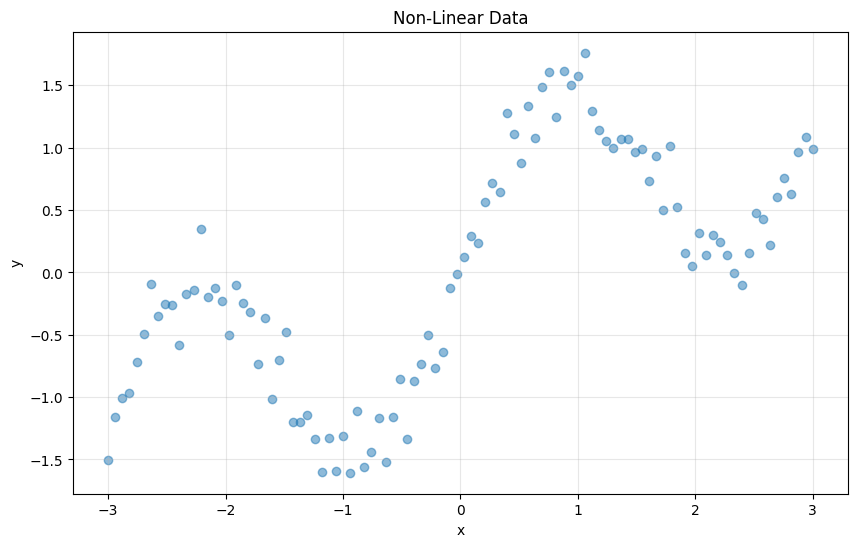

In [25]:
# Non-linear data
x_nl = np.linspace(-3, 3, 100)
y_nl = np.sin(2*x_nl) + 0.5*x_nl + np.random.normal(0, 0.2, 100)

plt.figure(figsize=(10, 6))
plt.scatter(x_nl, y_nl, alpha=0.5)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Non-Linear Data')
plt.grid(alpha=0.3); plt.show()

### Exercise 6.1: Polynomial Regression

In [ ]:
def polynomial_features(x, degree):
    """Create polynomial features"""
    # YOUR CODE HERE
    raise NotImplementedError()
    # YOUR CODE HERE
    raise NotImplementedError()

def fit_polynomial(x, y, degree):
    """Fit using normal equation"""
    # YOUR CODE HERE
    raise NotImplementedError()
    # YOUR CODE HERE
    raise NotImplementedError()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, deg in enumerate([1, 5, 15]):
    w = fit_polynomial(x_nl, y_nl, deg)
    x_plot = np.linspace(-3, 3, 200)
    y_plot = polynomial_features(x_plot, deg) @ w
    
    axes[idx].scatter(x_nl, y_nl, alpha=0.5)
    axes[idx].plot(x_plot, y_plot, 'r-', linewidth=2)
    axes[idx].set_title(f'Degree {deg}')
    axes[idx].set_ylim(-3, 3)
    axes[idx].grid(alpha=0.3)
plt.tight_layout(); plt.show()

## Part 7: Probabilistic Perspective

### Theory: Maximum Likelihood

MSE loss emerges naturally from assuming Gaussian noise.

In [ ]:
# Visualize likelihood
y_obs = 5.0
predictions = np.linspace(0, 10, 100)
sigma = 1.0
likelihood = norm.pdf(y_obs, loc=predictions, scale=sigma)

plt.figure(figsize=(10, 6))
plt.plot(predictions, likelihood, linewidth=2)
plt.axvline(y_obs, color='r', linestyle='--', label=f'y={y_obs}')
plt.xlabel('Prediction'); plt.ylabel('Likelihood')
plt.title('Likelihood Function')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

### Exercise 7.1: Confidence Intervals

In [ ]:
def prediction_intervals(x_train, y_train, x_pred, degree=5):
    """Compute predictions with confidence intervals"""
    # YOUR CODE HERE
    raise NotImplementedError()
    # YOUR CODE HERE
    raise NotImplementedError()

x_plot = np.linspace(-3, 3, 200)
y_pred, y_lower, y_upper = prediction_intervals(x_nl, y_nl, x_plot)

plt.figure(figsize=(12, 6))
plt.scatter(x_nl, y_nl, alpha=0.5, label='Data')
plt.plot(x_plot, y_pred, 'r-', linewidth=2, label='Prediction')
plt.fill_between(x_plot, y_lower, y_upper, alpha=0.3, label='95% Confidence')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Predictions with Uncertainty')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

## Summary

### Key Concepts Covered:

1. Automatic Differentiation: Chain rule and computational graphs
2. Linear Regression: Closed-form solution
3. Loss Functions: MSE, MAE, Huber
4. Gradient Descent: Iterative optimization
5. LBFGS: Second-order methods
6. Kernels: Non-linear transformations
7. Probability: Maximum likelihood equals minimum loss